# Homework 1

### Installing packages

In [2]:
!pip install langchain_google_genai


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.4/719.4 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.5/236.5 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.43.0
    Uninstalling google-auth-2.43.0:
      Successfully uninstalled google-auth-2.43.0
  Attempting uninstall: google-genai
    Found existing installation: google-genai 1.55.0
    Uninstalling google-genai-1.55.0:
      Successfully uninstalled google-genai-1.55.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires google-auth==2.43.0, but you have google-auth 2.48.0 which is incompatible.


## Setup your API key

To run the following cell, your API key must be stored it in a Colab Secret named `VERTEX_API_KEY`.


1.   Look for the key icon on the left panel of your colab.
2.   Under `Name`, create `VERTEX_API_KEY`.
3. Copy your key to `Value`.




In [3]:
from google.colab import userdata
GEMINI_VERTEX_API_KEY = userdata.get('VERTEX_API_KEY')

## Downloading receipts.zip
The codes below download and unzip receipts.zip from Google Drive. receipts.zip contains all images from the Fusion folder on BlackBoard.


In [4]:
import gdown
file_id = "1oe2FZd3ZTO7nrDqjCafNvxicl08oF8JF"
download_url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(download_url, "receipts.zip", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1oe2FZd3ZTO7nrDqjCafNvxicl08oF8JF
To: /content/receipts.zip
100%|██████████| 1.61M/1.61M [00:00<00:00, 51.3MB/s]


'receipts.zip'

In [5]:
!unzip receipts.zip

Archive:  receipts.zip
  inflating: receipt1.jpg            
  inflating: __MACOSX/._receipt1.jpg  
  inflating: receipt2.jpg            
  inflating: __MACOSX/._receipt2.jpg  
  inflating: receipt3.jpg            
  inflating: __MACOSX/._receipt3.jpg  
  inflating: receipt4.jpg            
  inflating: __MACOSX/._receipt4.jpg  
  inflating: receipt5.jpg            
  inflating: __MACOSX/._receipt5.jpg  
  inflating: receipt6.jpg            
  inflating: __MACOSX/._receipt6.jpg  
  inflating: receipt7.jpg            
  inflating: __MACOSX/._receipt7.jpg  


## 1. Helper functions

We need two functions
* image_to_base64 convert your jpg image into Base64 encoded string (basically a sequence of 64 characters to make your image easily transfered via API)
* get_image_data_url takes your jpg image, converting them into base64 string and construct a suitable input for GEMINI api call.

In [6]:
import base64
import mimetypes

# Helper function to read and encode image
def image_to_base64(img_path):
    with open(img_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

# Helper function to encode local file to Base64 Data URL
def get_image_data_url(image_path):
    # Guess the mime type (e.g., image/png, image/jpeg) based on file extension
    mime_type, _ = mimetypes.guess_type(image_path)
    if mime_type is None:
        mime_type = "image/png" # Default fallback

    encoded_string = image_to_base64(image_path)

    # Construct the Data URL
    return f"data:{mime_type};base64,{encoded_string}"

In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    api_key=userdata.get('VERTEX_API_KEY'), # Ensure this key is set in Colab secrets
    temperature=0,
    vertexai=True
)

Display jpg images. Alternatively, open the folder icon on the left pannel to see the images.


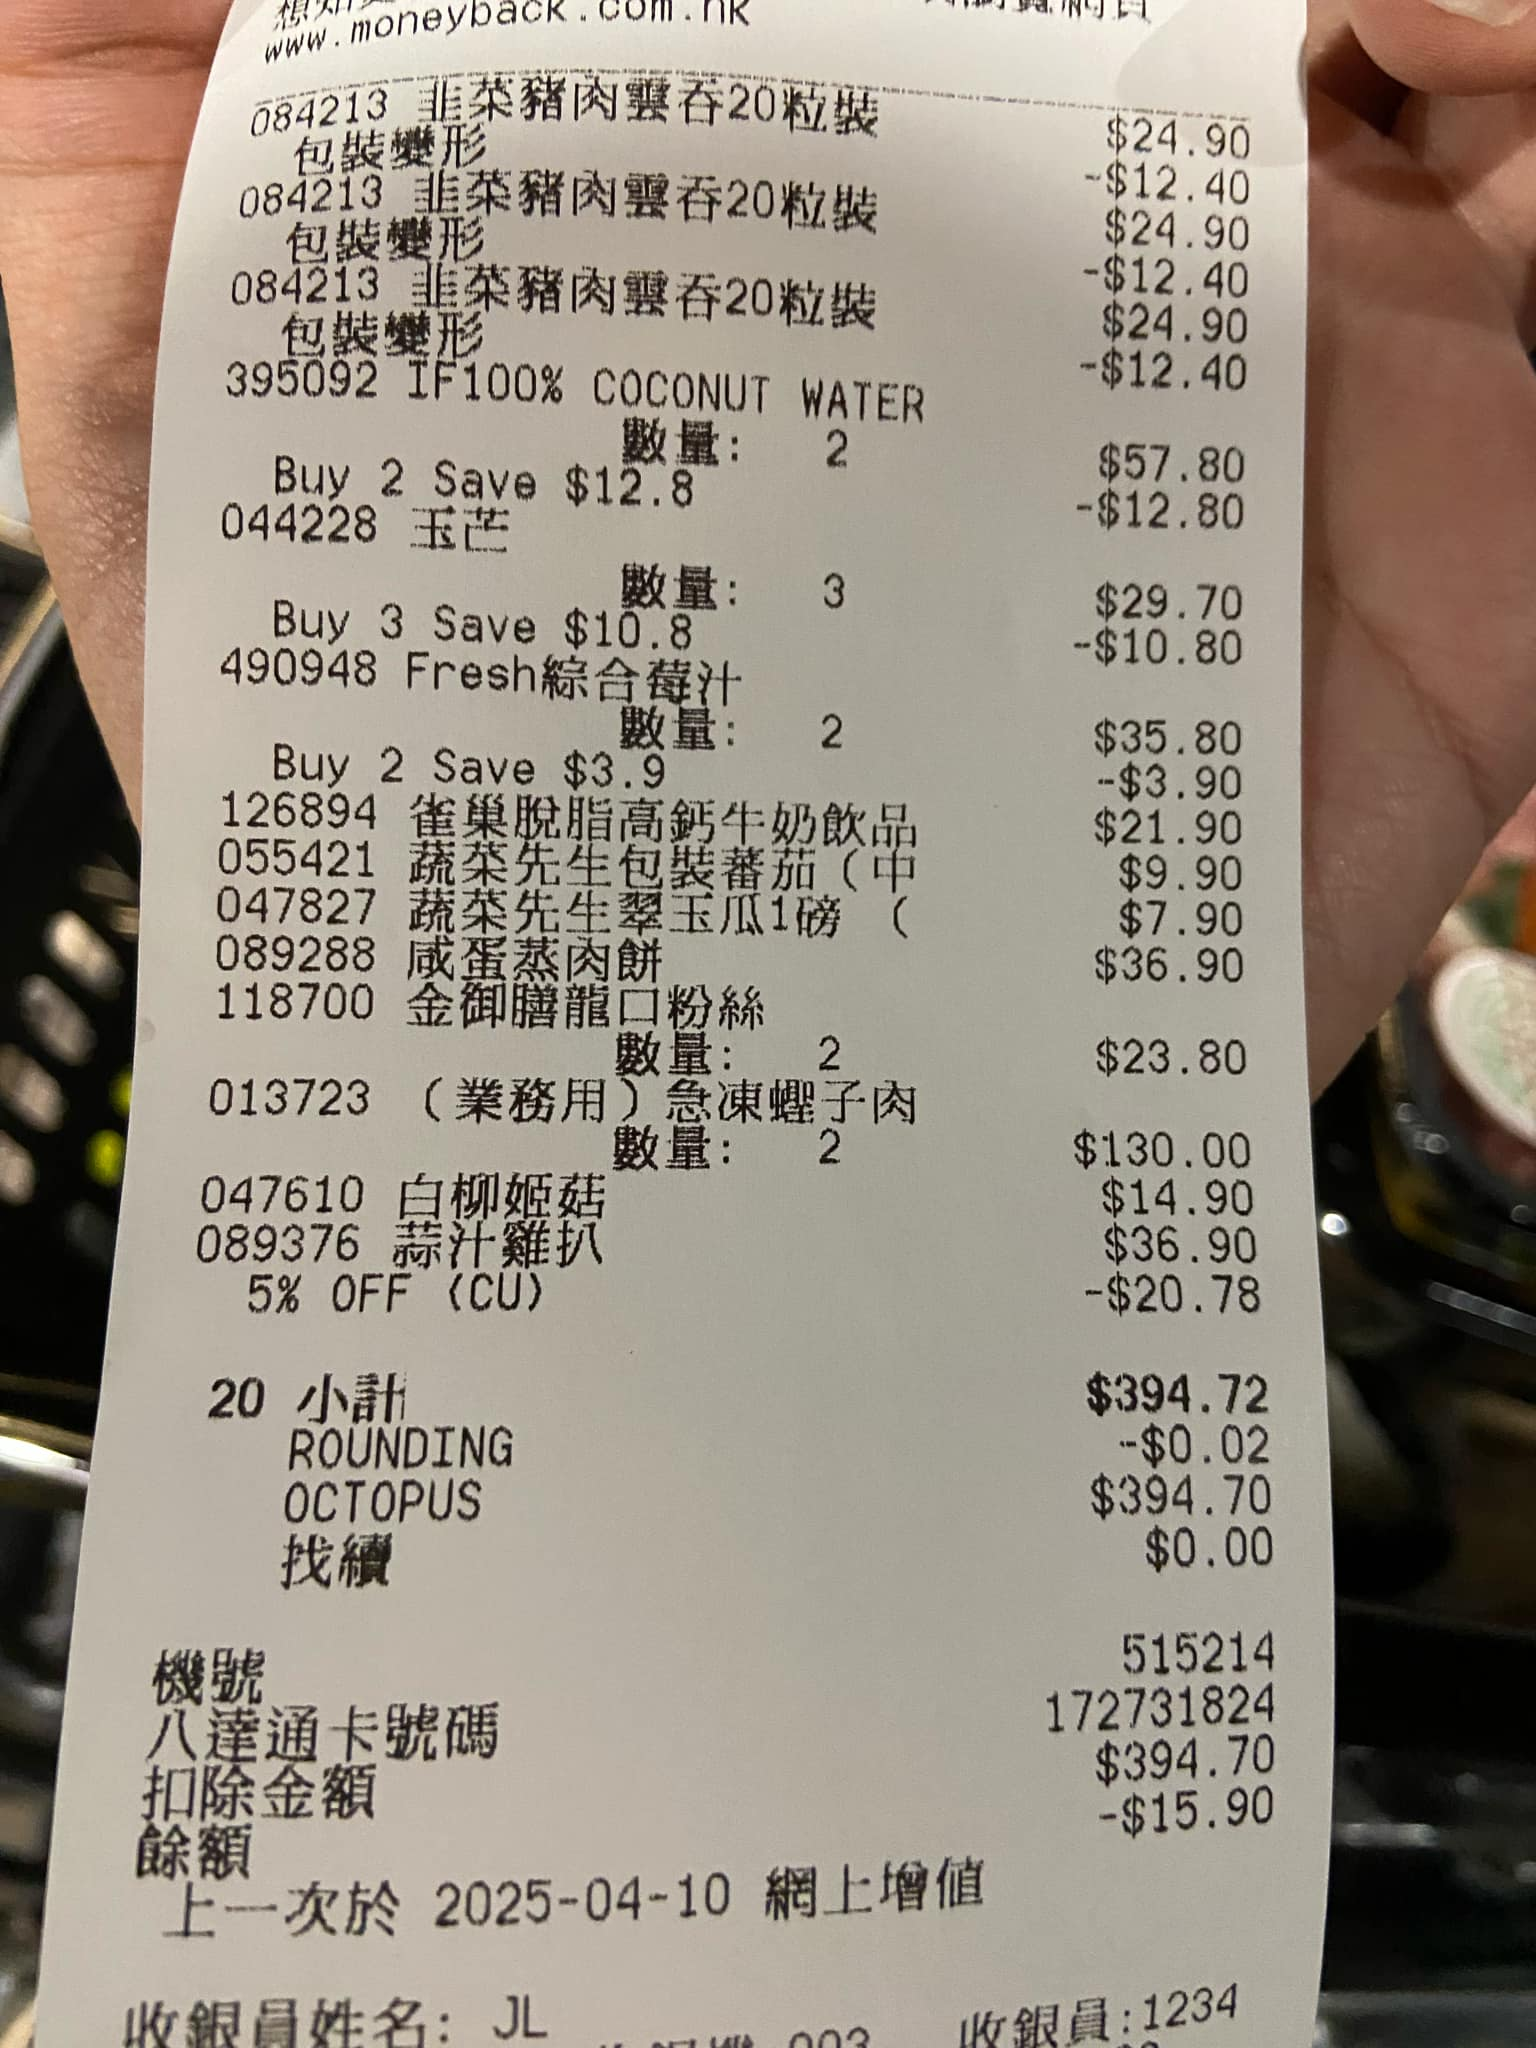
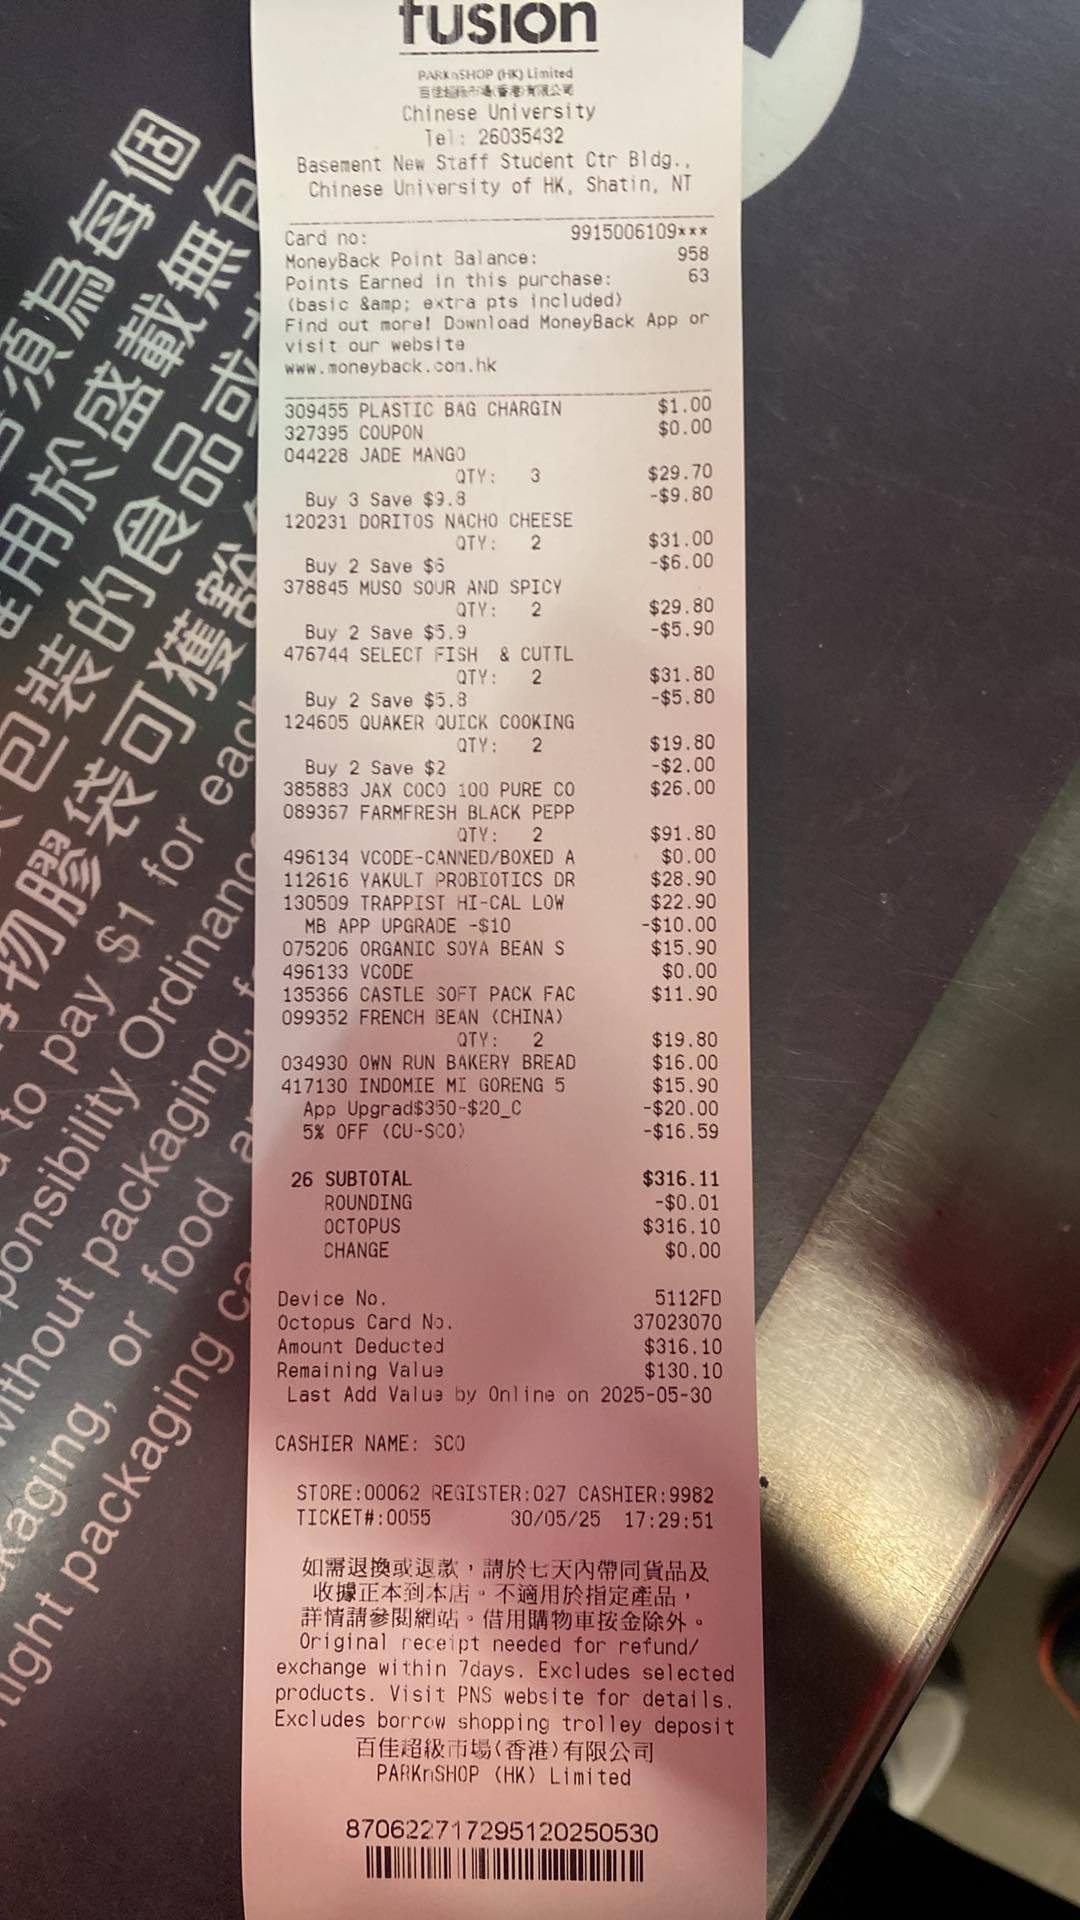
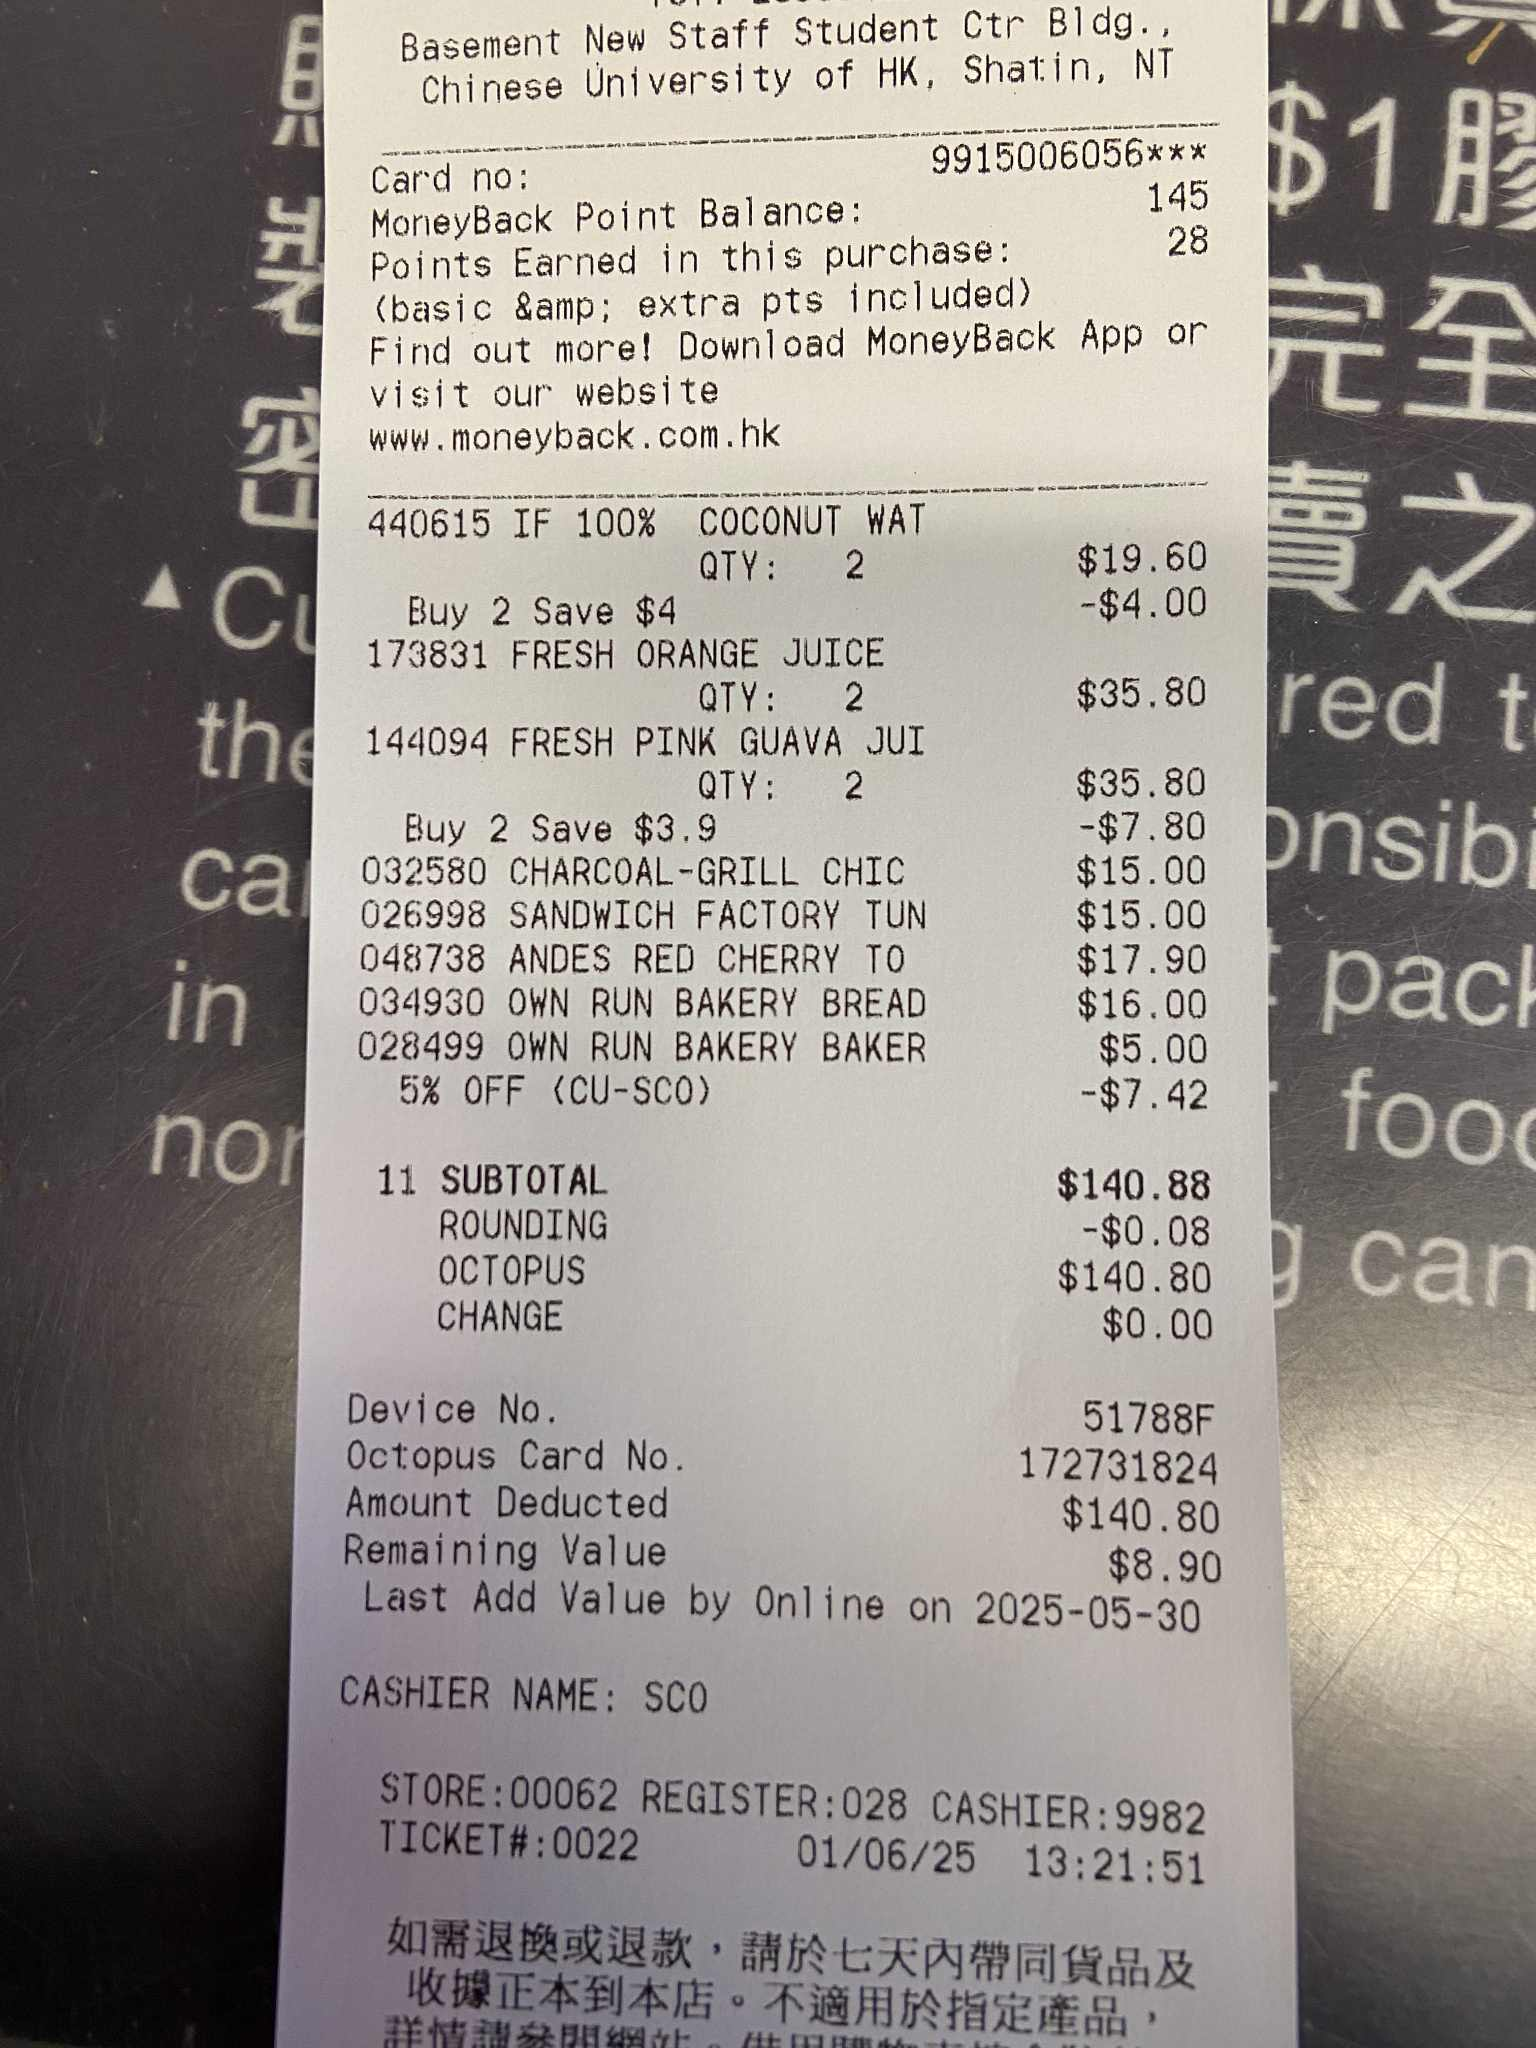
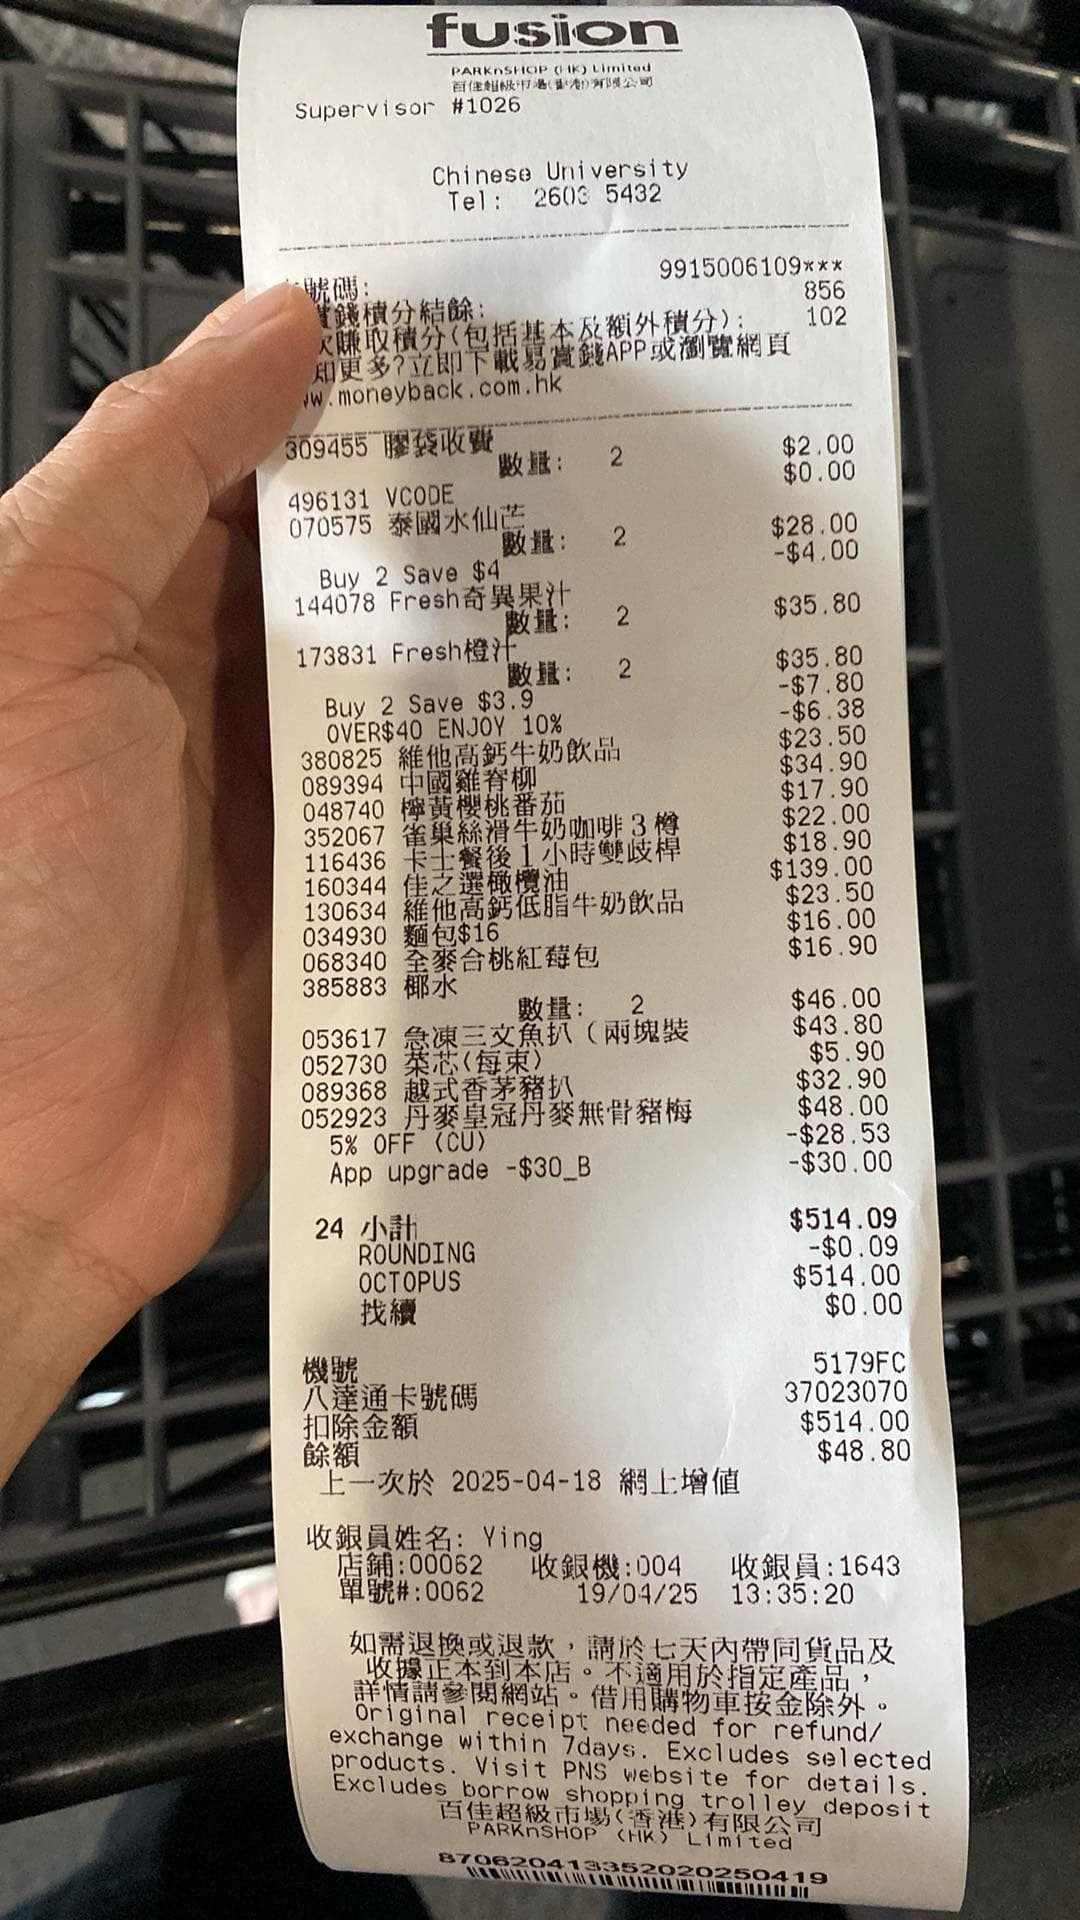
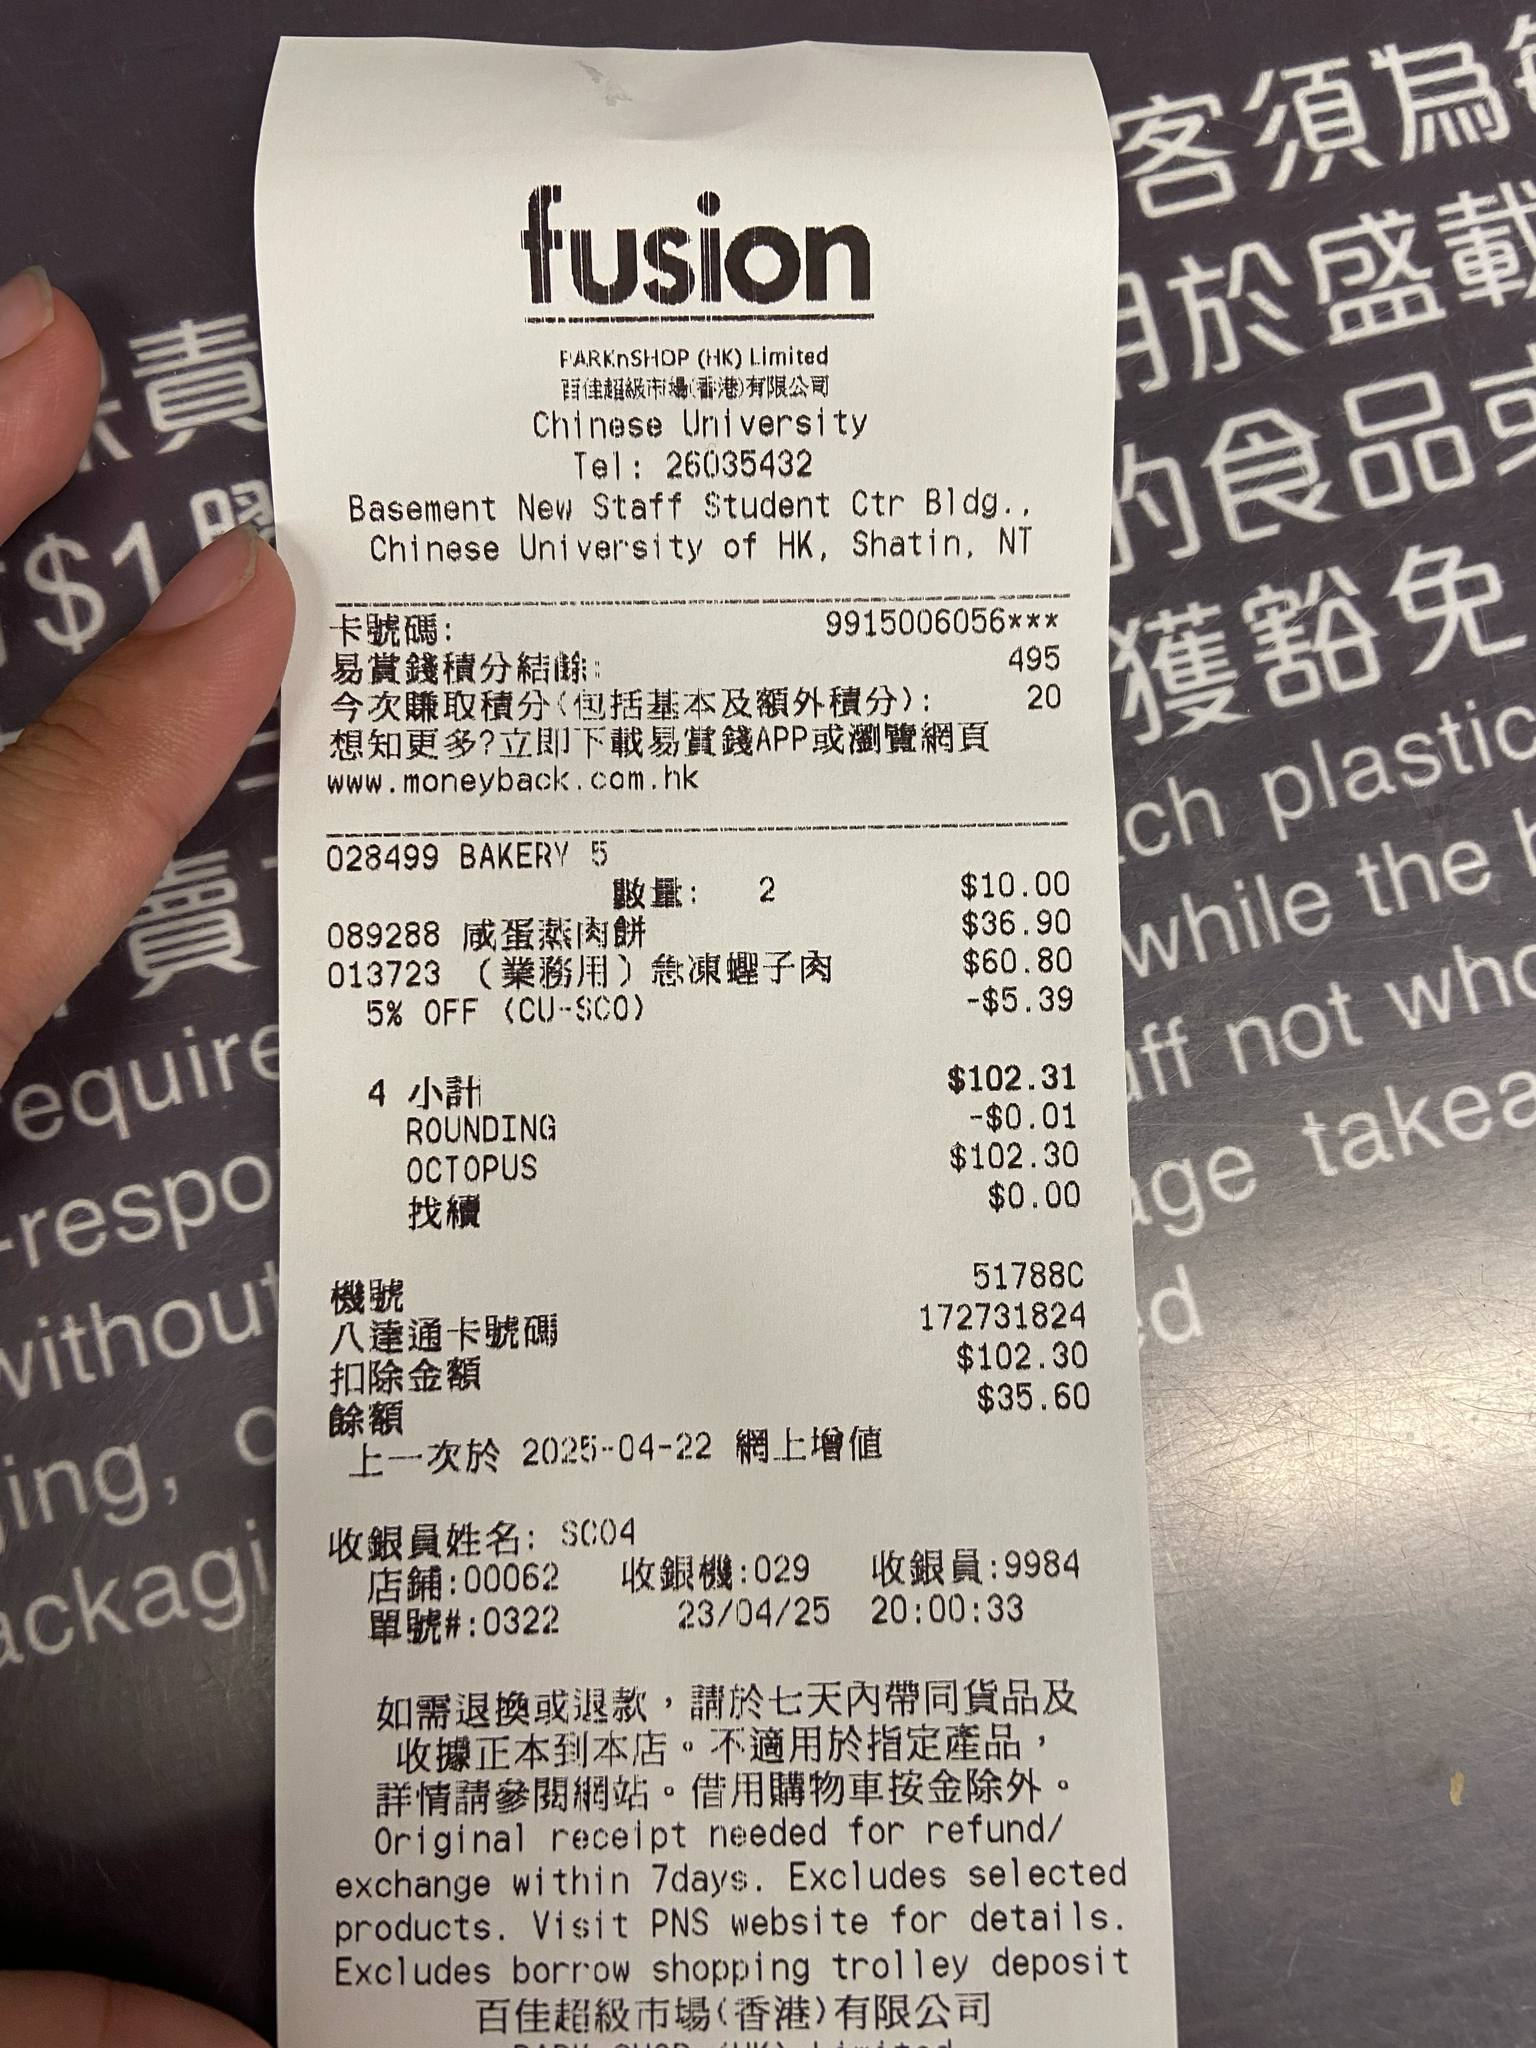
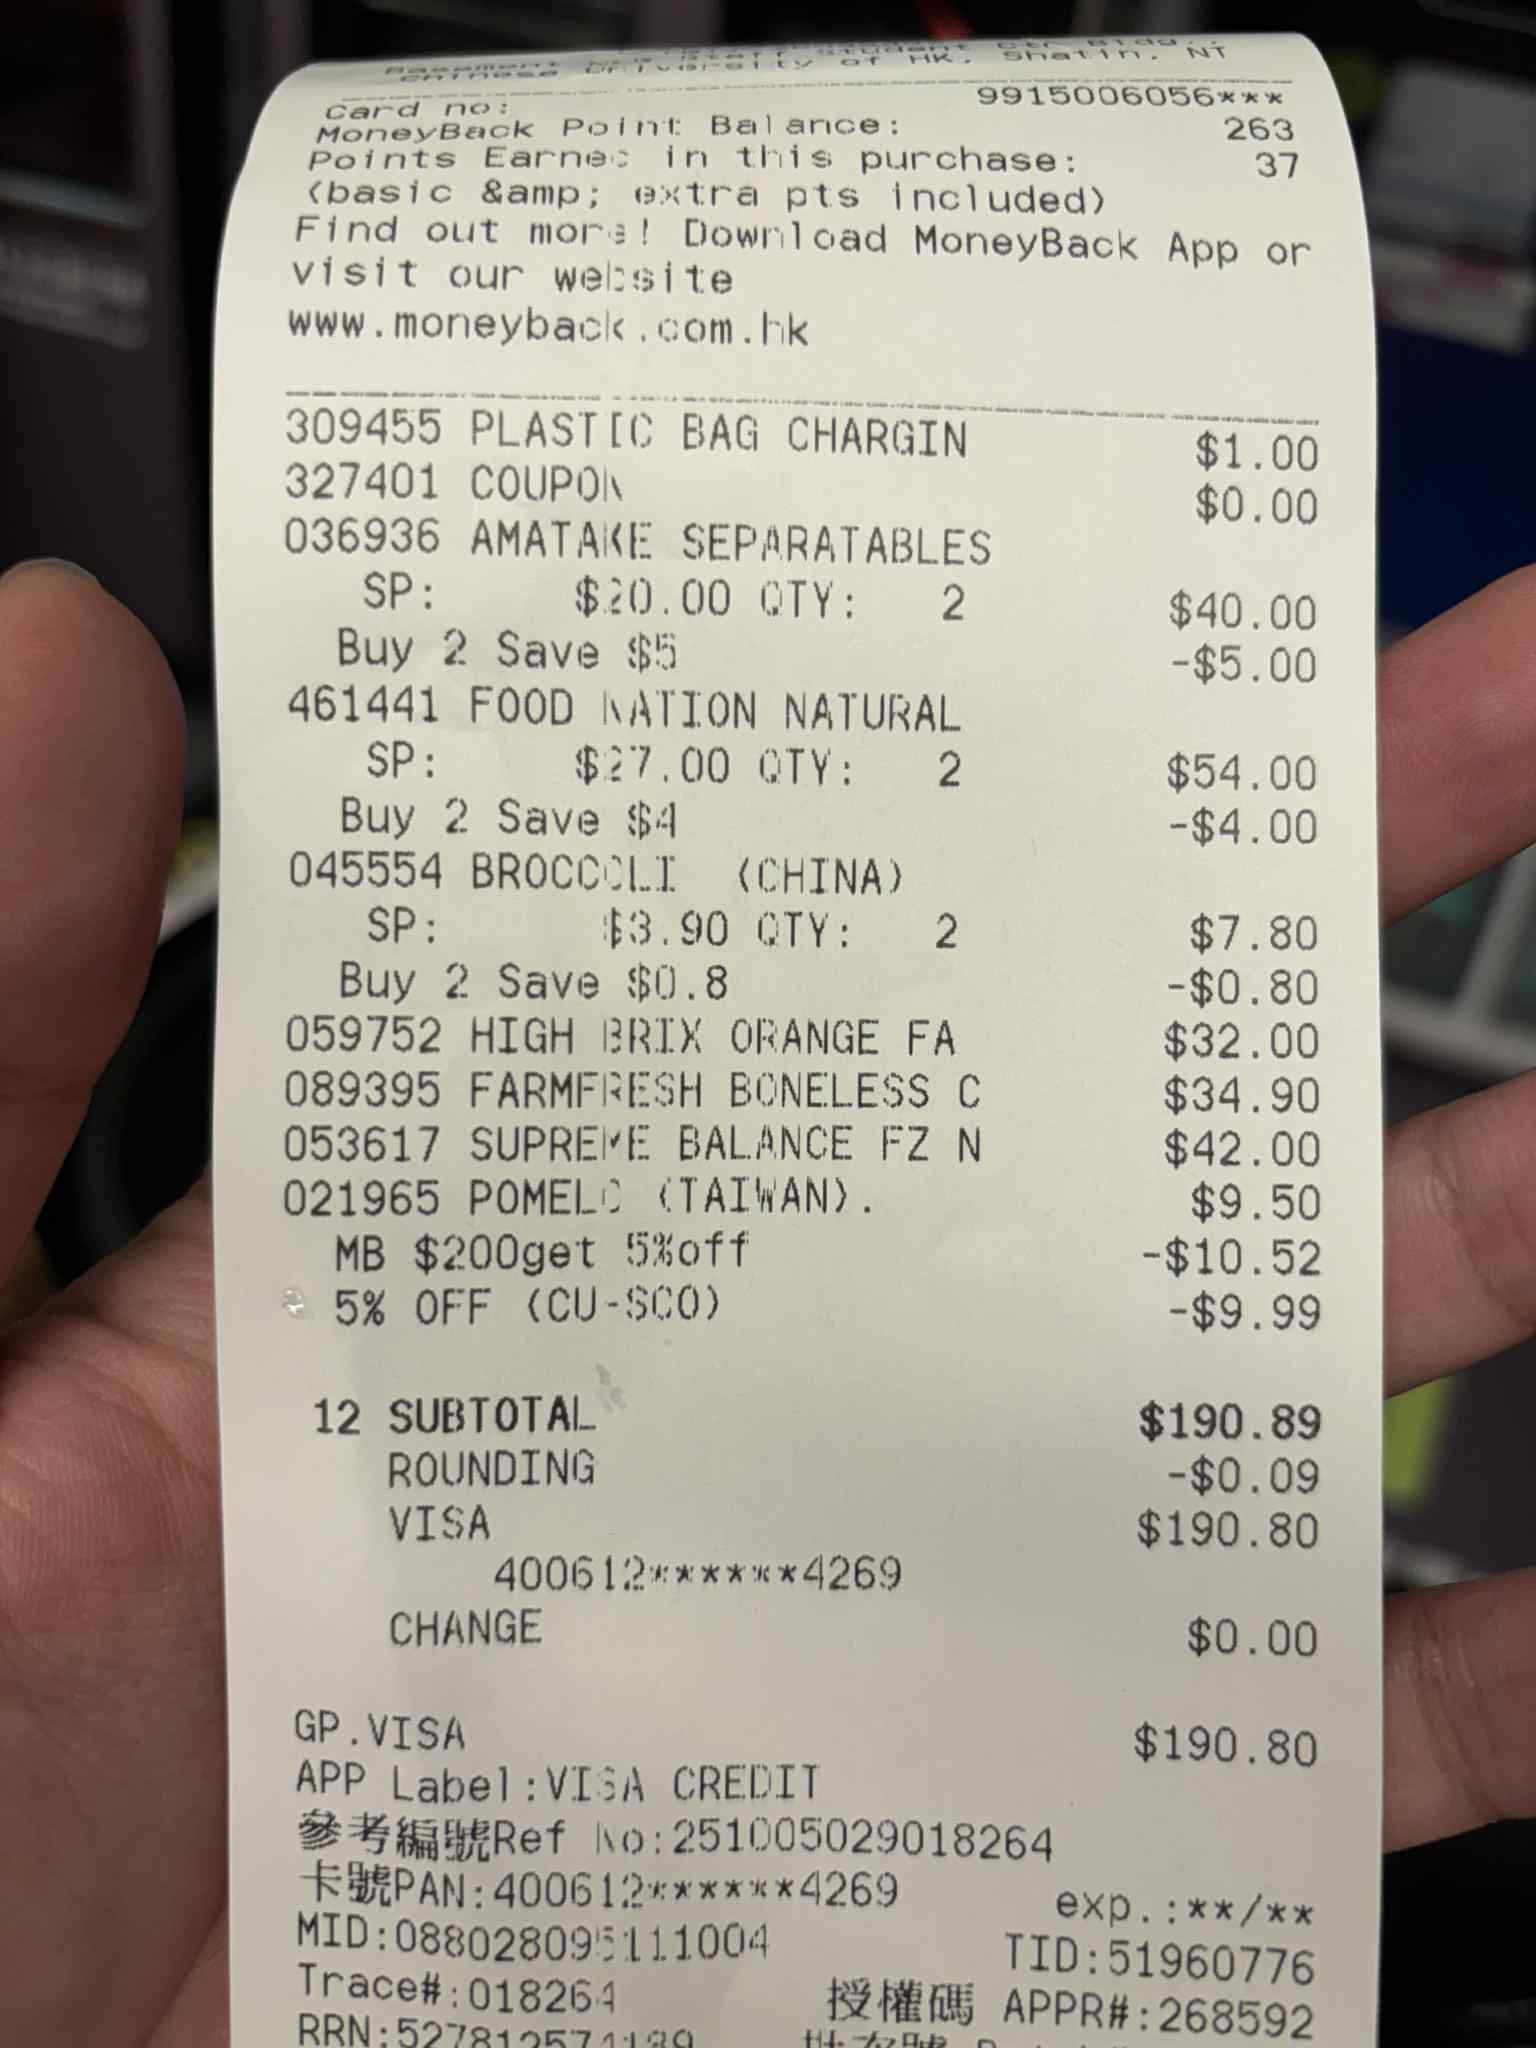
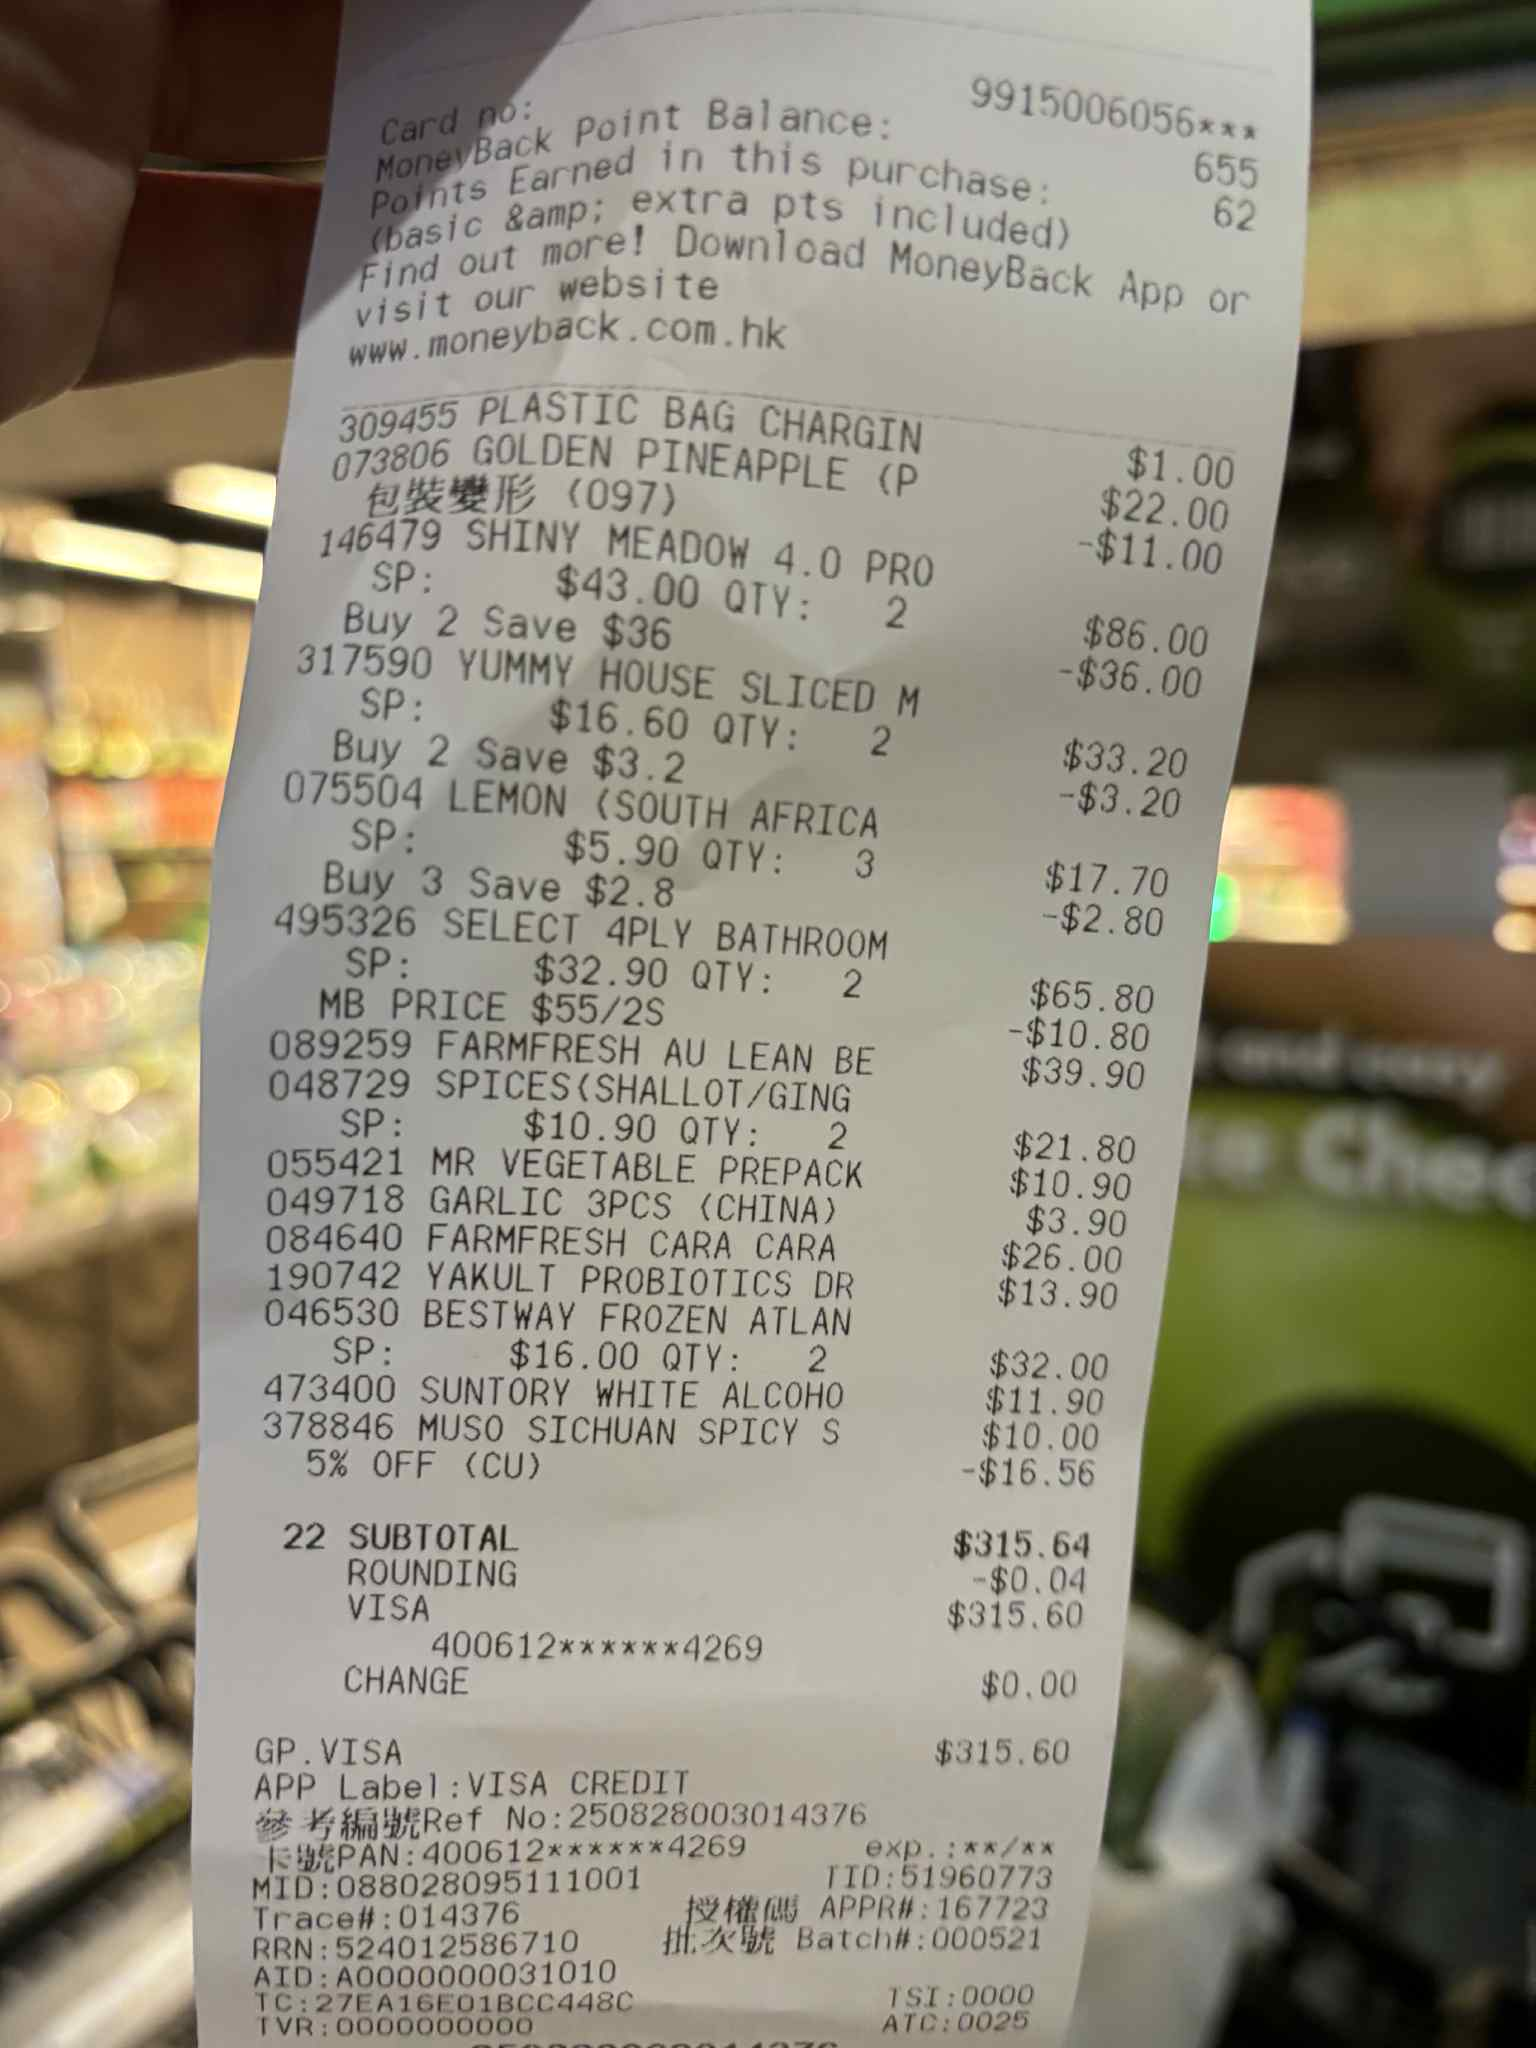

In [8]:
from IPython.display import HTML, display
import glob, os

image_paths = glob.glob("*.jpg")
image_paths.sort()
html_content = '<div style="display: flex; flex-wrap: wrap; gap: 20px;">'

for path in image_paths:
    b64 = image_to_base64(path)
    filename = os.path.basename(path) # Clean up path to show just the name

    # Create a vertical column for each image + text
    html_content += f'''
    <div style="display: flex; flex-direction: column; align-items: center;">
        <img src="data:image/jpeg;base64,{b64}" style="height: 300px; border: 1px solid #ddd; margin-bottom: 5px;"/>
        <span style="font-family: monospace; font-size: 14px;">{filename}</span>
    </div>
    '''

html_content += '</div>'

display(HTML(html_content))

## 2. Image input to Gemini
Different from text, image needs to be converted into base64 encoded string and then formated into url before inputting to the language model. This is convenient for image-type input to be transfered through the API.

You can find out more appropriate format for image-type data in this [Link](https://docs.langchain.com/oss/python/langchain/messages)



In [9]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.runnables import RunnableParallel, RunnablePassthrough, RunnableBranch, RunnableLambda
from langchain_core.tools import tool as langchain_tool
from langchain_core.tools import tool

In [10]:
classification_system_prompt = """You are a query classification agent.

Your task is to classify the user's question into exactly ONE of the following categories:

A: The user asks for the total amount actually paid across all provided receipts.
B: The user asks for the total amount before discount across all provided receipts.
C: The question is irrelevant, ambiguous, or outside the scope of receipt total calculation.

Rules:
- Only output a single capital letter: A, B, or C.
- Do NOT provide explanations or additional text.
- If the question does not clearly belong to A or B, choose C.
"""

classification_prompt = ChatPromptTemplate.from_messages([
    ("system", classification_system_prompt),
    ("user", "User question:\n{question}")
])

classification_chain = classification_prompt | llm | StrOutputParser()

In [11]:
extraction_system_prompt = """You are an information extraction agent.

Given an image of a supermarket receipt, extract all explicitly shown purchase information.

1. Purchased items:
For each item, extract:
- item_id: a unique integer ID starting from 1
- item_name
- unit_price (if shown)
- quantity (if shown)
- item_subtotal (if shown)

2. Discounts:
For each explicitly shown discount, extract:
- discount_id: a unique integer ID starting from 1
- discount_value: numeric value of the discount

3. Receipt-level information:
- receipt_total_paid (if shown)

Rules:
- Extract only information explicitly visible in the image.
- Strictly distinguish which ones are discounts.
- ROUNDING also belongs to discount.
- Do NOT calculate totals or infer discount applicability.
- Do NOT guess missing information.
- If information is unclear, set the field to null or "unknown".
- Output valid JSON only. No extra text.

Output format:
{{
  "items": [],
  "discounts": [],
  "receipt_total_paid": null
}}
"""

extraction_prompt = ChatPromptTemplate.from_messages([
    ("system", extraction_system_prompt),
    ("user", [
        {
            "type": "image_url",
            "image_url": {"url": "{image_url}"}
        }
    ])
])

extraction_chain = extraction_prompt | llm | JsonOutputParser()

In [20]:
def type_a_handler(extracted_data) -> str:
  """
  Handles questions belong to query1.
  """
  grand_total_paid = 0.0
  for receipt in extracted_data:
    paid = receipt.get("receipt_total_paid") or 0.0
    if isinstance(paid, (int, float)):
      grand_total_paid += paid
  return f"{grand_total_paid:.2f}"

def type_b_handler(extracted_data) -> str:
  """
  Handles questions belong to query2.
  """
  total_without_discount = 0.0
  for receipt in extracted_data:
    paid = receipt.get("receipt_total_paid") or 0.0
    discounts_list = receipt.get("discounts", [])
    receipt_discounts = sum([d.get("discount_value", 0) for d in discounts_list if d.get("discount_value")])
    total_without_discount += (paid + receipt_discounts)
  return f"{total_without_discount:.2f}"

In [13]:
def master_coordinator(prompt):
    decision = classification_chain.invoke({"question": prompt["question"]}).strip().upper()

    if decision == "C":
        return "I cannot answer this question."

    extracted_data = extraction_chain.batch([{"image_url": url} for url in prompt["image_urls"]])

    if decision == "A":
      return type_a_handler(extracted_data)
    elif decision == "B":
      return type_b_handler(extracted_data)

## 3. Evaluation Code

* Make sure your LLM return a single float as the answer, stored in `query1_answer` and `query2_answer`
* Run the following code blocks: (1) If the blocks does not return any error, then your chain design is correct. Otherwise, please check your chain design.

* Do not modify `query_1_costs` and `query_2_costs`

In [14]:
def test_query(answer, ground_truth_costs):
    # Convert string to float if necessary
    if isinstance(answer, str):
        answer = float(answer)

    # Calculate the ground truth sum once for clarity
    expected_total = sum(ground_truth_costs)

    # Check if the answer is within +/- $2 of the expected total
    assert abs(answer - expected_total) <= 2

Run the following code block to evaluate query 1:
> How much money did I spend in total for these bills?

In [15]:
query_1_costs = [394.7, 316.1, 140.8, 514.0, 102.3, 190.8, 315.6] # do not modify this

query1 = "How much money did I spend in total for these bills?"
image_paths = ["/content/receipt1.jpg", "/content/receipt2.jpg", "/content/receipt3.jpg", "/content/receipt4.jpg", "/content/receipt5.jpg", "/content/receipt6.jpg", "/content/receipt7.jpg"]
image_urls = [get_image_data_url(image_path) for image_path in image_paths]
human_prompt1 = {
    "question": query1,
    "image_urls": image_urls
}

query1_answer = master_coordinator(human_prompt1)
test_query(query1_answer, query_1_costs)

Run the following code block to evaluate query 2:
> How much would I have had to pay without the discount?

In [17]:
query_2_costs = [480.20, 392.20, 160.10, 590.80, 107.70, 221.20, 396.00] # do not modify this

query2 = "How much would I have had to pay without the discount?"
human_prompt2 = {
    "question": query2,
    "image_urls": image_urls
}

query2_answer = master_coordinator(human_prompt2)
test_query(query2_answer, query_2_costs)

In [18]:
sum([480.20, 392.20, 160.10, 590.80, 107.70, 221.20, 396.00])

2348.2

In [19]:
query3 = "How much would I spend in total for the first item of these bills"
human_prompt3 = {
    "question": query3,
    "image_urls": image_urls
}
query3_answer = master_coordinator(human_prompt3)
print(query3_answer)

I cannot answer this question.
